## SciPy


### Généralités

Vous l'aurez peut-être remarqué, si vous êtes un afficionado de MATLAB : certaines fonctions de votre programme préféré _manquent à l'appel !_. Par exemple, nous n'avons pas vu comment résoudre numériquement une équation différentielle, comment ajuster (_fitter_) des données autrement que par une droite, comment filtrer un signal, chercher les maxima d'une fonction ou ses zéros, etc. etc. C'est le but du module `Scipy`.

Scipy s'appuie principalement sur NumPy, donc je vous conseille d'avoir jeté un oeil au [tutoriel NumPy](./Application_A_Numpy.ipynb) et d'avoir les bases de [Matplotlib](./Application_B_Matplotlib.ipynb) afin de ne pas être trop perdu.e. 

### Filtrage

Choisissons un signal $e(t)$ à temps _continu_. Filtrer ce signal revient à _convoluer_ celui-ci par une fonction de réponse $h(t)$: 

$$ s(t) = (h * e)(t) =  \int_{-\infty}^{\infty} e(\tau) h(t - \tau) {\rm d}\tau$$

Cette fonction $h$ peut être pensée pour dériver, intégrer, multiplier, etc. la fonction initiale $s(t)$. 

Dans cette section, en fonction de vos usages, nous allons voir comment filtrer des signaux : 

* En utilisant des filtres basés sur des _fonctions de transfert_, c'est à dire en travaillant dans l'espace de Fourier.
* En construisant explicitement des _fenêtres_ de filtrage $h(t)$. 
* En utilisant l'algorithme de _Savitsky-Golay_.

#### Fonctions de transfert
 
Dans cette section, nous allons apprendre à définir des fonctions de transfert 'à l'ancienne', c'est à dire dans l'espace de Fourier, puis de voir comment les 'convertir' en filtres numériques afin de les appliquer à des signaux échantillonnés régulièrement. Je vous montrerai enfin comment directement définir des filtres numériques qui se rapprochent de ces comportements.

##### Quelques rappels 

Les fonctions de transfert $H(j\omega)$ sont simplement les transformées de Fourier des fenêtres $h(t)$ que nous avons évoquées ci-dessus. Travailler dans l'espace de Fourier est très pratique car la convolution $*$ devient alors une simple multiplication $\times$, et les dérivations successives ou intégrations deviennent de simples facteurs $(j\omega)$ ou $(1/j\omega)$. On comprend alors tout l'intérêt d'effectuer : 

$$ s(t) = h(t) * e(t) \leadsto S(\omega) = H(j\omega) E(\omega)$$

Les années de licence ou de prépa nous ont également habitués à jouer avec des fonctions de transfert. On sait qu'elles ont pour forme habituelle quelque chose du genre : 

$$ H(j\omega) = \frac{b_0 (j\omega)^n + b_1 (j \omega)^{n-1} + ... + b_{n-1} (j \omega) +  b_n }{a_0 (j\omega)^n + a_1 (j \omega)^{n-1} + ... + a_{n-1} (j\omega) + a_n} $$

L'exemple général est un peu intimidant, mais si je décide unilatéralement que $b_n = a_n = 1$ et $a_{n-1} = 1/\omega_0$ et que tous les autres coefficients sont nuls, ma fonction de transfert devient : 

$$ H(\omega) = \frac{1}{1 + j \omega/\omega_0} $$ 

C'est à dire un bête filtre passe-bas d'ordre 1 de fréquence de coupure $\omega_0$ ! Chouette non ?

##### Afficher les fonctions de transfert : diagrammes de Bode

Scipy permet de _visualiser_ la réponse fréquentielle d'un filtre défini avec des $a_i$ et des $b_i$ via la fonction `scipy.signal.freqs()`. Cette fonction demande en entrée :
* les listes (ou tableaux) $b$ des coefficients $b_i$ de la puissance la plus élevée [$(j\omega)^n$] à la plus faible [$(j\omega)^0$].
* la même chose pour la liste $a$ des coefficients $a_i$.
* `worN` (lire $\omega$ or $N$) : le nombre (entier) de fréquences auxquelles vous voulez que votre filtre soit tracé, ou la liste explicite des fréquences qui vous intéressent.

La longueur maximale des tableaux $a$ et $b$, notée $n+1$, va définir l'_ordre_ du filtre que vous allez créer, qui sera donc _a priori_ $n$, à part, bien entendu, si vous mettez des zéros partout :-). Examinons le cas de notre filtre d'ordre 1 :

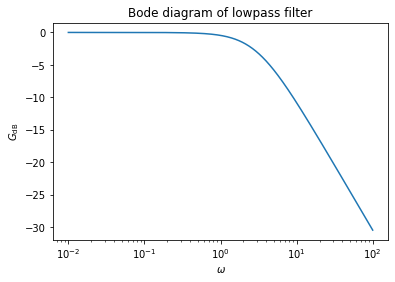

In [236]:
import scipy.signal as spsi
import matplotlib.pyplot as plt
import numpy as np

omega_0 = 3
a = [1/omega_0,1]     
b = [0,1]

#            b_0 (jw) + b_1           1
#   H (w) = ----------------- = --------------
#            a_0 (jw) + a_1       jw/w_0 + 1

w, h_w = spsi.freqs(b,a, worN=np.logspace(-2,2,1000))
fig, ax = plt.subplots()
ax.semilogx(w, 20*np.log10(np.abs(h_w)))
ax.set_title('Bode diagram')
ax.set_ylabel('$G_{\\rm dB}$')
ax.set_xlabel('$\omega$')
plt.show()

Je vous laisse vérifier qu'on a bien $-20 {\rm dB}$ par décade aux hautes fréquences, et que le $-3 {\rm dB}$ est bien atteint pour $\omega = \omega_0$.



__Exercices__ : 
* Créez un filtre passe-haut du deuxième ordre en précisant vous-même les coefficients $a$ et $b$ de votre filtre.
* Tracez la réponse _en phase_ du filtre de l'exercice précédent.

In [ ]:
# The ghost of undone homework is getting restless
#  .-.
# (o o)  "Doooo youuurrr exerrrciiissseeeesssss"
# | O \        
# \   \        
#  `~~~'

##### Quelques filtres analogiques

Vous vous douterez peut-être que les choses vont _un peu_ se corser si vous voulez appliquer des filtres d'ordre plus élevé, contrôler les facteurs de qualité ou faire de la réjection de bandes, etc. Ne vous inquiétez pas, _Scipy_ est là pour vous aider, et possède en fait des [filtres 'standards'](https://docs.scipy.org/doc/scipy/reference/signal.html#matlab-style-iir-filter-design) qui vont calculer les tableaux $a$ et $b$ pour vous. Par exemple, il est possible d'utiliser des filtres [Butterworth](https://fr.wikipedia.org/wiki/Filtre_de_Butterworth) avec la fonction `scipy.signal.butter()` qui prend en entrée : 

- L'ordre du filtre $n$
- La fréquence de coupure $\omega_0$ pour les filtres passe-bas ou haut ou les fréquences de coupure $(\omega_0, \omega_1)$ pour les filtres passe-bande ou coupe-bande. Celles-ci sont précisées en ${\rm rad}\cdot{\rm s}^{-1}$.
- `btype`, qui va préciser le type de filtre, par exemple `'lowpass'`, `'bandpass'`, `'bandstop'`, ...
- `analog`, que nous allons laisser à `True` pour l'instant.

Tentons de créer un filtre passe-bas d'ordre 2 de cette manière et examinons les coefficients $a$ et $b$

In [115]:
import scipy.signal as spsi

b, a = spsi.butter(2, 0.5, analog=True, btype='lowpass')

print(b)
print(a)

[0.25]
[1.         0.70710678 0.25      ]


La fonction de transfert que nous avons obtenue a donc la forme suivante : 

$$ |H(j\omega)| = \frac{1}{-4\omega^2 + 2 \sqrt{2} j\omega  + 1} \leadsto |H(j\omega)| = \frac{1}{\sqrt{1 + 16 \omega^4}}$$ 

C'est à dire la définition d'un filtre [Butterworth](https://fr.wikipedia.org/wiki/Filtre_de_Butterworth) d'ordre 2 avec $\omega_0 = 0.5~{\rm rad}\cdot{\rm s}^{-1}$. 

##### Appliquer des filtres analogiques

Dessiner des filtres, c'est bien joli, mais comment fait-on pour les _appliquer_ à un signal ? On peut pour cela utiliser _deux_ fonctions : 

* `scipy.signal.lfilter()` va filtrer le signal une fois
* `scipy.signal.filtfilt()` va appliquer _deux fois_ le filtre. Une première fois sur le signal initial à l'endroit, puis ensuite sur le signal filtré une fois mais _retourné temporellement_. 

Ces fonctions prennent bien en entrée : 
* les coefficients du numérateur $b$ 
* ceux du dénominateur, $a$
* et le signal $x$ 

Essayons de filtrer un signal correspondant à une sinusoïde de fréquence 1 Hz à laquelle nous avons ajouté du bruit :

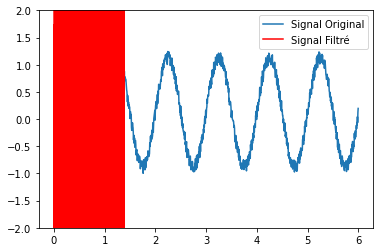

In [147]:
import numpy as np
import scipy.signal as spsi
import matplotlib.pyplot as plt

# Defining variables, then noise and filter
t = np.arange(0,6,0.005)                                 # Sampling frequency is 200 Hz
noise = 0.25*np.random.uniform(size=len(t))
e = np.sin(2*np.pi*t) + noise
b, a = spsi.butter(2, 4*np.pi, analog=True)             # Choosing f = 2 Hz for cutoff
s = spsi.lfilter(b, a, e)

# Plotting area
fig, ax = plt.subplots()
ax.plot(t,e, label='Signal Original')
ax.plot(t,s, 'r', label='Signal Filtré')
ax.legend()
plt.ylim([-2,2])
plt.show()

![img](./resources/kevin_horror.jpg)

__Que se passe-t-il ?!?__ : En fait, je vous ai un peu menti ... Les coefficients $a$ et $b$ à spécifier lors de l'appel aux fonctions `lfilter()` et `filtfilt()` ne sont pas ceux de l'espace de Fourier ... mais ceux de l'espace de la [transformée en Z](https://fr.wikipedia.org/wiki/Transformation_en_Z) ! En effet, notre signal n'est pas continu, mais _échantillonné_ à temps discret. Je choisis de volontairement ne pas en dire plus.

__Pour vous en sortir, vous devrez utiliser la fonction `scipy.signal.bilinear()`__. Celle-ci va prendre en entrée vos $a$ et $b$ analogiques et les transformer en $a_z$ et $b_z$ de la transformée en $Z$. Vous pouvez également lui passer l'argument `fs` correspondant à la fréquence d'échantillonnage de votre signal. Essayons de corriger le tir de la débâcle précédente :

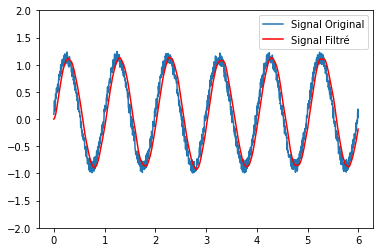

In [148]:
# Defining variables, then noise and filter
t = np.arange(0,6,0.005)                                 # Sampling frequency is 200 Hz
noise = 0.25*np.random.uniform(size=len(t))
e = np.sin(2*np.pi*t) + noise
b, a = spsi.butter(2, 10*np.pi, analog=True)              # Choosing f = 5 Hz for cutoff
bz, az = spsi.bilinear(b, a, fs=1/0.005)
s = spsi.lfilter(bz, az, e)

# Plotting area
fig, ax = plt.subplots()
ax.plot(t,e, label='Signal Original')
ax.plot(t,s, 'r', label='Signal Filtré')
ax.legend()
plt.ylim([-2,2])
plt.show()

Ah ! C'est bien mieux ! Le signal filtré et le signal original se ressemblent déjà bien plus. Cependant, le signal filtré est (légèrement) décalé en temps à cause du _déphasage_ lié au filtre. On peut corriger le tir en appliquant une deuxième fois le filtre, cette fois-ci sur le signal _retourné dans le temps_, puis en remettant _à l'endroit_ le résultat. C'est le concept de la fonction `filtfilt()` : 

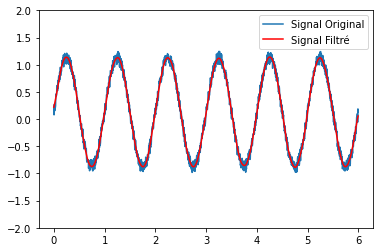

In [226]:
# Defining variables, then noise and filter
t = np.arange(0,6,0.005)                                 # Sampling frequency is 200 Hz
noise = 0.25*np.random.uniform(size=len(t))
e = np.sin(2*np.pi*t) + noise
b, a = spsi.butter(2, 10*np.pi, analog=True)              # Choosing f = 3 Hz for cutoff
bz, az = spsi.bilinear(b, a, fs=1/0.005)
s = spsi.filtfilt(bz, az, e)

# Plotting area
fig, ax = plt.subplots()
ax.plot(t,e, label='Signal Original')
ax.plot(t,s, 'r', label='Signal Filtré')
ax.legend()
plt.ylim([-2,2])
plt.show()

##### Il y avait plus rapide ... les filtres numériques !

On peut en fait _directement_ obtenir les coefficients $a$ et $b$ de vos filtres préférés dans l'espace de la transformée en $Z$ si on ... _enlève_ la condition `analog=True` lors de la construction de notre filtre ! Oups ... :-) . Dans un tel cas, 

* lors de la création de votre filtre, je vous conseille de préciser la fréquence d'échantillonnage $f_s$ de votre signal. Vous pourrez alors choisir des fréquences $f_0$ de coupure entre $0$ et $f_s/2$. Par défaut, $f_s=2$ et $f_c$ est alors comprise entre 0 et 1.
* si vous voulez examiner la réponse fréquentielle de votre filtre _--cette fois-ci numérique --, vous devrez utiliser la fonction `scipy.signal.freqz()` avec un __z__ et pas un __s__.  

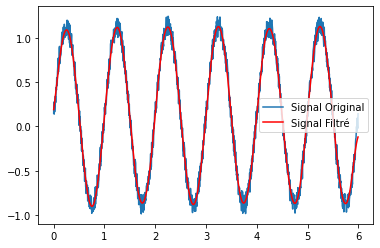

In [175]:
# Defining variables, then noise and filter
t = np.arange(0,6,0.005)                                 # Sampling frequency is 200 Hz
noise = 0.25*np.random.uniform(size=len(t))
e = np.sin(2*np.pi*t) + noise
bz, az = spsi.butter(2, 3, fs=1/0.005)                  # Choosing f = 3 Hz for cutoff
s = spsi.filtfilt(bz,az,e)

# Plotting area
fig, ax = plt.subplots()
ax.plot(t,e, label='Signal Original')
ax.plot(t,s, 'r', label='Signal Filtré')
ax.legend()
plt.show()

__Exercices__ : 
* Comparez le diagramme de Bode d'un filtre analogique de Butterworth (celui qui vous chante) avec sa version numérique. 
* Le signal suivant contient trois composantes en fréquence ($0.2$, $1$ et $3$ Hz). Essayez de définir un filtre numérique permettant de ne garder que la composante à 1 Hz. 

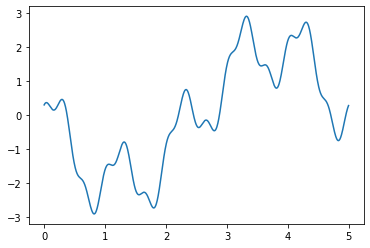

In [162]:
t = np.arange(0,5,0.005)
e = np.sin(2*np.pi*t) - 2*np.sin(2*np.pi*0.2*t) + 0.3*np.cos(2*np.pi*3*t) 

# Plotting area : add your filtered plot here !
fig, ax = plt.subplots()
ax.plot(t,e)
plt.show()

#### Fonctions de fenêtrage

Si vous êtes plutôt du genre _espace direct_, vous pouvez également faire appel à des fonctions de fenêtrage explicites $h(t)$ parmi la [longue liste](https://docs.scipy.org/doc/scipy/reference/signal.windows.html) de fenêtres disponibles. Un choix assez classique consiste à choisir la fenêtre de [Hann](https://en.wikipedia.org/wiki/Hann_function), `scipy.signal.windows.hann()`, qui ne prend en entrée qu'un nombre $M$ de points, c'est à dire le nombre de points sur lequel on va effectuer le filtrage. Comme vous l'aurez constaté, ces fenêtres vont principalement _lisser_ le signal en effectuant un filtrage _passe-bas_ typiquement sur $M$ points, c'est à dire avec une fréquence de coupure de l'ordre de $f_s/M$.

Pour filtrer le signal avec ces fenêtres, on va ensuite simplement appeler la fonction `np.convolve()` ou `scipy.signal.convolve()` afin de calculer : 

$$ s(t) = (h * e) (t)$$

Par défaut, ces fenêtres ne sont pas normalisées, donc faites un tour par la case `sum()` pour la normaliser et voir votre filtre en action. Le tour est joué !

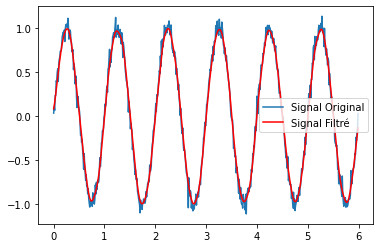

In [182]:
import numpy as np
import scipy.signal as spsi

t = np.arange(0,6,1/100)            # Sampling frequency : 100 Hz
noise = 0.25*np.random.normal(size=len(t))
e = np.sin(2*np.pi*t) + 0.25*noise
window = spsi.windows.hann(20)      # Cutoff frequency : 100/20 = 5 Hz
window_norm = window/sum(window)
s = np.convolve(e, window_norm, mode='same')

# Plotting area
fig, ax = plt.subplots()
ax.plot(t,e, label='Signal Original')
ax.plot(t,s, 'r', label='Signal Filtré')
ax.legend()
plt.show()

__Exercice__ (difficile) : Essayez de développer une fenêtre permettant de dériver un signal (aux basses fréquences) tout en filtrant les hautes fréquences. Vous pouvez partir de la relation bien connue des [amateurs de distributions](https://fr.wikipedia.org/wiki/Distribution_(math%C3%A9matiques)) : 

$$ (e * h')(t) = \int e(\tau) h'(t - \tau) {\rm d}\tau = - \int e'(\tau) h(t - \tau)~{\rm d}\tau = (e' * h) (t) $$

#### Le filtre de Savitsky-Golay

Dans la catégorie 'inclassables', le filtre de [Savistky-Golay](https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter) est un filtre assez pratique qui va essayer de fitter par un polynôme d'ordre assez faible des bouts de taille $M$ de votre signal à filtrer. Ce filtrage par des polynômes est assez intéressant car il permet en outre de calculer la dérivée de votre signal initial tout en limitant le bruit habituellement associé au calcul des dérivées.

La fonction `spsi.savgol_filter()` prend donc naturellement comme arguments : 
* $e$, le signal à filtrer
* $M$, le nombre de points des bouts de signaux à fitter : c'est en fait la 'taille' du filtre. Ce nombre doit être impair.
* `polyorder`, l'ordre du polynôme utilisé pour ajuster les données
* `deriv` [optionnel] : précisez un entier $n$ pour obtenir la $n^{\rm ème}$ dérivée du signal filtré.

Le filtre renvoie alors directement les

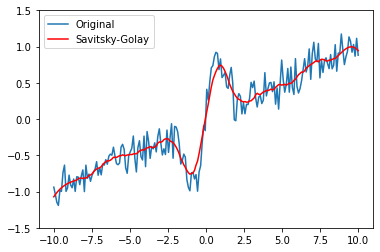

In [225]:
import numpy as np
import scipy.signal as spsi
import matplotlib.pyplot as plt

# Signal construction
t = np.linspace(-10,10,200)
noise = 0.15*np.random.normal(size=len(t))
e = noise + 2*t*np.exp(-t**2) + 0.1*t

# Signal filtering
s = spsi.savgol_filter(e, window_length=31, polyorder=3)

# Plotting area
fig, ax = plt.subplots()
ax.plot(t, e, label='Original')
ax.plot(t, s, 'r', label='Savitsky-Golay')
ax.legend()
ax.set_ylim([-1.5,1.5])
plt.show()

--------------------------------------------------------------------------

### Interpolation

L'interpolation de données s'effectue généralement lorsque les signaux qu'on mesure ne sont pas échantillonnés régulièrement. Certaines techniques, par exemple la [vélocimétrie laser Doppler](https://fr.wikipedia.org/wiki/V%C3%A9locim%C3%A9trie_laser), mesurent la vitesse locale dans un fluide ... mais seulement lorsqu'une particule traverse le faisceau laser ! Vous vous douterez bien que les traceurs ne vont pas gentiment s'organiser pour passer devant le détecteur à intervalles réguliers, et il est alors difficile, par exemple, de calculer le spectre de Fourier d'un tel signal.

Dans certains autres cas, il est parfois utile d'interpoler le signal pour avoir _plus de points_ de données que dans le jeu de données initial. Cela permet de combler certains trous et d'avoir un signal ou une image finaux d'aspect plus lisse, plus agréable à l'oeil.

Nous allons voir ici ce que le module `scipy.interpolate()` a dans le ventre !

#### Interpolation à une dimension 

L'interpolation à une dimension est une affaire assez simple et s'effectue avec la fonction `scipy.interpolate.interp1d()`. Vous aurez besoin pour cela de lui préciser : 
* les valeurs de $x$ sur lesquelles la fonction est calculée, qui n'est pas forcément trié.
* les valeurs de $y = f(x)$ de votre fonction aux $x$ précédemment mentionnés
* le _type_ (`kind`) d'interpolation, qui peut être au plus proche voisin (`'nearest'`), linéaire (`'linear'`), avec des splines cubiques (`'cubic'`), ...
* le comportement à avoir par rapport à l'extrapolation, avec `fill_value`: vous pouvez choisir un ou plusieurs nombres, ou préciser que vous voulez extrapoler les données avec `'extrapolate'`.

_La fonction `interp1d()` renvoie en retour un interpolateur_ : c'est l'estimation de la fonction $f$ obtenue par l'ordinateur. En pratique, c'est un objet à qui on va ensuite donner à manger la liste des points $x_i$ où l'on veut interpoler les données, et qui nous recrache les $f(x_i) = y_i$ qui nous intéressent. 

Essayons d'interpoler une fonction arbitraire à partir de données mal échantillonnées en $x$.

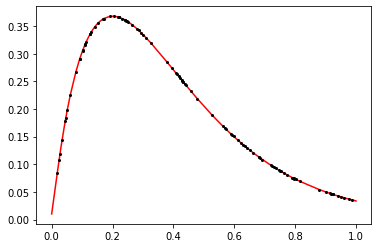

In [257]:
import numpy as np
import scipy.interpolate as spint
import matplotlib.pyplot as plt

x = np.random.uniform(size=100) # Irregular x values
y = 5*x*np.exp(-5*x)

interpolator = spint.interp1d(x, y, kind='linear', fill_value='extrapolate')
xi = np.linspace(0,1,100)
yi = interpolator(xi)

fig, ax = plt.subplots()
ax.plot(xi, yi, 'r')
ax.plot(x, y, 'ko', markerfacecolor='k', markersize=2)
plt.show()

Ces interpolateurs peuvent être très puissants pour atteindre la [_précision sous-pixel_](https://dsp.stackexchange.com/questions/34103/subpixel-what-is-it) qui est parfois recherchée pour localiser des petits déplacements de particules ou des légers déphasages entre deux signaux. 

Prenons un signal $y_i$ qui possède un pic théorique étroit en $x_0=0.02$, mais qui n'est pas échantillonné en $x = x_0$. En l'interpolant par une [_spline_](https://fr.wikipedia.org/wiki/Spline), on va essayer de _retrouver_ la position du maximum théorique .

_Note_ : Cette méthode _ne fonctionne pas_ avec des interpolations linéaires ou de plus proche voisin.

Naive        estimate of maximum : -0.000
Interpolated estimate of maximum : 0.022


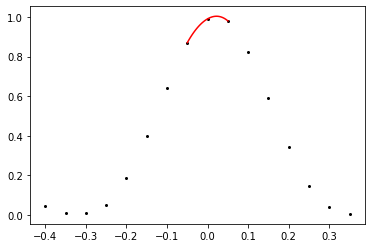

In [316]:
x = np.arange(-0.4,0.4,0.05)
noise = 0.01*np.random.uniform(size=len(x)) # Add a bit of noise to show the method is not perfect
y = np.sinc(3*(x-0.02))**2 + noise
x_0_naive = x[np.argmax(y)]

# Create the interpolator, then evaluate it close to x_0 with a smaller δx
interpolator = spint.interp1d(x, y, kind='cubic')
xi = np.linspace(x_0_naive-0.05,x_0_naive + 0.05,101)
yi = interpolator(xi)

# Check where we have found our maxima / compare with naive method
x_0_interp = xi[np.argmax(yi)]
print(f'Naive        estimate of maximum : {x_0_naive:.3f}')
print(f'Interpolated estimate of maximum : {x_0_interp:.3f}')

fig, ax = plt.subplots()
ax.plot(x , y , 'ko', markerfacecolor='k', markersize=2)
ax.plot(xi, yi, 'r')
plt.show()

Si vous répétez l'exécution de l'algorithme plusieurs fois, vous verrez que le maximum interpolé est bien détecté aux alentours de $x_0 = 0.02$ avec une variabilité de l'ordre de $\pm 0.003$, alors que le signal initial était faux de $0.02$ ! 

Pour ceux que cela embêterait, sachez que je n'ai pas extrait de l'information du néant pour obtenir ma valeur du maximum. Les _splines_ qui interpolent le signal entre $x_i$ et $x_{i+1}$ ne se basent pas jsute sur les valeurs $y_i$ et $y_{i+1}$. Elles exploitent également les informations du 'voisinage', c'est à dire $y_{i-1}, y_{i-2}, ..., y_{i+1}, y_{i+2}, ...$, qu'elles utilisent pour reconstruire plus fidèlement la fonction $f$.

Ce procédé de détection _sub-pixel_ de maxima est tout à fait applicable aux images à deux ou trois dimensions. Pratique pour déterminer le déplacement de petites particules sur de petites distances, ... par exemple dans un système de pinces optiques !

##